# License 
***
Copyright 2017 J. Patrick Hall, jphall@gwu.edu & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Local Feature Importance and Reason Codes using LOCO
***

Based on: Lei, Jing, G’Sell, Max, Rinaldo, Alessandro, Tibshirani, Ryan J., and Wasserman, Larry. Distribution-free predictive inference for regression. *Journal of the American Statistical Association*, 2017.

http://www.stat.cmu.edu/~ryantibs/papers/conformal.pdf

** Instead of dropping one variable and retraining a model to understand the importance of that variable in a model, these examples set a variable to missing and rescore this new, corrupted sample with the original model. This is approach may be more appropriate for nonlineaer models in which nonlinear dependencies can allow variables to nearly completely replace one another when a model is retrained. **

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o 
import numpy as np
import pandas as pd
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [2]:
# start h2o
h2o.init()
h2o.remove_all()
h2o.show_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/navdeepgill/anaconda/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/55/rj4cny_s29q4vn1wjt_x08sm0000gn/T/tmpm_tnb3
  JVM stdout: /var/folders/55/rj4cny_s29q4vn1wjt_x08sm0000gn/T/tmpm_tnb3/h2o_navdeepgill_started_from_python.out
  JVM stderr: /var/folders/55/rj4cny_s29q4vn1wjt_x08sm0000gn/T/tmpm_tnb3/h2o_navdeepgill_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,11 days
H2O cluster name:,H2O_from_python_navdeepgill_1zqh1k
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


#### Load and prepare data for modeling

In [3]:
# load clean data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### LOCO is simpler to use with data containing no missing values

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')
_ = frame[enums].impute(method='mode')

In [6]:
# split into training and validation
train, valid = frame.split_frame([0.7])

#### Understanding linear correlation and nonlinear dependencies are important for LOCO.
* If strong relationships are present, retraining the model after removing an input will simply allow the linearly correlated or nonlinearly dependent variables to make up for the impact of the removed input. This why we will set to missing here, and **not** drop and retrain.
* If such relationships are present, models must be regularized to prevent correlation or other dependencies from creating instability in model parameters or rules. (H2O GBM is regularized by column and row sampling.)
* For H2O GBM, setting a variable to missing causes it to follow the majority path in each decision tree. The interpretation of LOCO becomes the numeric difference between the local behavior of the variable and the most common local behavior.
* Because of linear correlation and nonlinear dependence, LOCO values are valid only for a given data and feature set. 

In [7]:
# print out linearly correlated pairs
corr = train[reals].cor().as_data_frame()
for i in range(0, corr.shape[0]):
    for j in range(0, corr.shape[1]):
        if i != j:
            if np.abs(corr.iat[i, j]) > 0.7:
                print(corr.columns[i], corr.columns[j])

('GarageYrBlt', 'YearBuilt')
('GrLivArea', 'TotRmsAbvGrd')
('YearBuilt', 'GarageYrBlt')
('1stFlrSF', 'TotalBsmtSF')
('TotalBsmtSF', '1stFlrSF')
('TotRmsAbvGrd', 'GrLivArea')
('GarageArea', 'GarageCars')
('GarageCars', 'GarageArea')


It's likely that even more nonlinearly dependent relationships exist between inputs. Nonlinearly relationships can also behave differently at global and local scales.

#### Removing one var from each correlated pair may increase stability in the model and its explanations

In [8]:
X_reals_decorr = [i for i in reals if i not in  ['GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF', 'GarageCars']]

## Train a predictive model

In [9]:
# train GBM model
model = H2OGradientBoostingEstimator(ntrees=100,
                                     max_depth=10,
                                     distribution='huber',
                                     learn_rate=0.1,
                                     stopping_rounds=5,
                                     seed=12345)

model.train(y=y, x=X_reals_decorr, training_frame=train, validation_frame=valid)

preds = valid['Id'].cbind(model.predict(valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


## Rescore predictive model
* Each time leaving one input (covariate) out by setting it to missing
* To generate local feature importance values for each decision

In [10]:
h2o.no_progress()

for k, i in enumerate(X_reals_decorr):

    # train and predict with Xi set to missing
    valid_loco = h2o.deep_copy(valid, 'valid_loco')
    valid_loco[i] = np.nan
    preds_loco = model.predict(valid_loco)
    
    # create a new, named column for the LOCO prediction
    preds_loco.columns = [i]
    preds = preds.cbind(preds_loco)
    
    # subtract the LOCO prediction from 
    preds[i] = preds[i] - preds['predict']
    
    print('LOCO Progress: ' + i + ' (' + str(k+1) + '/' + str(len(X_reals_decorr)) + ') ...')
    
print('Done.')  

preds.head()

LOCO Progress: 3SsnPorch (1/32) ...
LOCO Progress: OverallQual (2/32) ...
LOCO Progress: LotArea (3/32) ...
LOCO Progress: GrLivArea (4/32) ...
LOCO Progress: YearRemodAdd (5/32) ...
LOCO Progress: EnclosedPorch (6/32) ...
LOCO Progress: BsmtFullBath (7/32) ...
LOCO Progress: LotFrontage (8/32) ...
LOCO Progress: KitchenAbvGr (9/32) ...
LOCO Progress: MoSold (10/32) ...
LOCO Progress: OpenPorchSF (11/32) ...
LOCO Progress: BsmtUnfSF (12/32) ...
LOCO Progress: FullBath (13/32) ...
LOCO Progress: MSSubClass (14/32) ...
LOCO Progress: YearBuilt (15/32) ...
LOCO Progress: PoolArea (16/32) ...
LOCO Progress: LowQualFinSF (17/32) ...
LOCO Progress: 2ndFlrSF (18/32) ...
LOCO Progress: HalfBath (19/32) ...
LOCO Progress: OverallCond (20/32) ...
LOCO Progress: WoodDeckSF (21/32) ...
LOCO Progress: MasVnrArea (22/32) ...
LOCO Progress: 1stFlrSF (23/32) ...
LOCO Progress: MiscVal (24/32) ...
LOCO Progress: Fireplaces (25/32) ...
LOCO Progress: BsmtHalfBath (26/32) ...
LOCO Progress: YrSold (27/32

Id,predict,3SsnPorch,OverallQual,LotArea,GrLivArea,YearRemodAdd,EnclosedPorch,BsmtFullBath,LotFrontage,KitchenAbvGr,MoSold,OpenPorchSF,BsmtUnfSF,FullBath,MSSubClass,YearBuilt,PoolArea,LowQualFinSF,2ndFlrSF,HalfBath,OverallCond,WoodDeckSF,MasVnrArea,1stFlrSF,MiscVal,Fireplaces,BsmtHalfBath,YrSold,BsmtFinSF1,BsmtFinSF2,ScreenPorch,BedroomAbvGr,GarageArea
3,219669,0,-29672.8,-1842.28,-20642.4,-1553.97,0,644.04,4215.53,0,1366.83,779.964,-194.699,0,-2150.73,-3175.83,0,0,4387.69,1135.81,0,552.362,508.887,8601.44,0,-906.323,0,0,-2605.98,0,0,0,-7670.35
5,305626,0,-84644.3,-3149.24,-5193.99,7357.58,0,996.119,-2581.92,0,8194.09,293.259,-1421.65,0,0,-1811,0,0,-1696.73,-513.491,0,-913.395,-683.321,9583.2,0,0,0,-220.908,-860.999,0,0,0,-29579.7
11,132835,0,203.503,-1552.12,3269.56,2541.27,0,-505.083,-773.066,0,252.899,1043.16,585.852,0,1018.39,0,0,0,0,0,2651.22,0,0,377.193,0,2064.28,0,0,-3320.07,0,0,156.415,849.442
17,146752,0,-9272.72,-3716.28,9248.1,2582.43,0,-153.634,0,0,459.067,0,411.278,0,-894.895,206.248,0,0,0,0,-1917.83,0,423.194,-187.085,0,340.351,0,871.497,-706.887,0,0,0,-1721.67
18,121835,0,3771.09,19.3633,-1495.18,831.685,0,0,563.803,1041.42,-300.123,0,5030.9,-7058.8,4495.39,185.039,0,0,743.97,0,802.889,0,0,-3824.37,0,5506.36,0,-45.078,7629.3,0,0,474.567,-1889.01
21,323753,0,-122020,-5894.11,-30490.2,-7095.22,0,0,-3228.57,0,7041.86,-1041.19,2184.8,-8936.85,0,-10578.2,0,0,-1141.99,685.831,0,-7677.91,-8603.46,5848.7,0,0,0,0,39873.2,0,0,0,-13757.2
24,140779,0,-1709.46,5650.03,9922.57,-2468.43,0,261.4,5158.92,0,0,-2795.57,0,0,-1254.71,-1834.46,0,0,-110.215,0,-2293.03,-723.293,0,-775.353,0,-2478.49,0,1020.46,-2420.33,0,0,0,-2187.26
25,142326,0,268.423,861.367,6064.59,-5545.37,0,-99.2566,0,0,0,1356.7,636.835,0,852.146,-2528.14,0,0,0,0,-781.549,-281.692,0,-10881.4,0,-828.635,0,939.163,4174.74,-5782.99,0,156.415,13359.4
27,127410,0,-292.733,1821.56,7614.96,-4471.56,0,434.405,299.43,0,0,199.68,1456.6,0,0,999.945,0,0,397.849,0,-1232.15,-770.748,0,5523.22,0,336.627,-1677.73,504.44,2415.54,-7.84971,0,150.809,-7918.21
29,182020,0,-3786.64,-13604,-23785.3,-1144.37,0,-1074.71,1509.65,0,-1788.5,-4412.3,0,0,-168.19,1507.81,0,0,0,0,-2873.93,-393.519,0,-6042.55,0,-4903.48,0,-37.6849,-20593.8,0,0,-1179.18,3300.35


The numeric values in each column are an estimate of how much each variable contributed to each decision. These values can tell you how a variable and it's values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders must provide reasons for turning down a credit application, even for automated decisions. Reason codes can be easily extracted from LOCO local feature importance values, by simply ranking the variables that played the largest role in any given decision.

#### Helper function for finding quantile indices

In [11]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

quantile_dict = get_quantile_dict('predict', 'Id', preds)
print(quantile_dict)

{0: 1338.0, 99: 524.0, 70: 447.0, 40: 1205.0, 10: 269.0, 80: 221.0, 50: 64.0, 20: 985.0, 90: 307.0, 60: 1259.0, 30: 1451.0}


#### Plot some reason codes for a representative row

In [12]:
%matplotlib inline

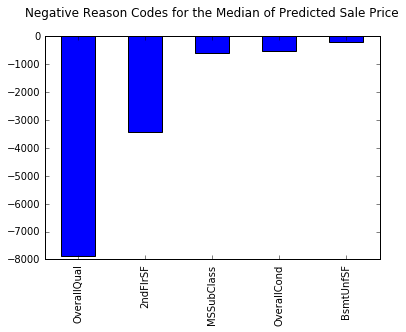

In [13]:
median_loco = preds[preds['Id'] == int(quantile_dict[50]), :].as_data_frame().drop(['Id', 'predict'], axis=1)
median_loco = median_loco.T.sort_values(by=0)[:5]
_ = median_loco.plot(kind='bar', 
                     title='Negative Reason Codes for the Median of Predicted Sale Price\n', 
                     legend=False)

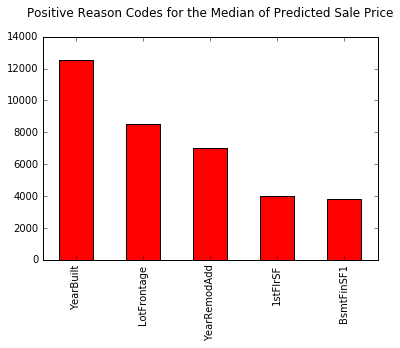

In [14]:
median_loco = preds[preds['Id'] == int(quantile_dict[50]), :].as_data_frame().drop(['Id', 'predict'], axis=1)
median_loco = median_loco.T.sort_values(by=0, ascending=False)[:5]
_ = median_loco.plot(kind='bar', 
                     title='Positive Reason Codes for the Median of Predicted Sale Price\n', 
                     color='r',
                     legend=False)

## Ensembling explantions to reduce local variance
Explanations derived from high variance machine learning models can be unstable. One general way to decrease variance is to ensemble the results of many models.

#### Train multiple models

In [15]:
n_models = 10 # select number of models

models = []
pred_frames = []

for i in range(0, n_models):

    # store models
    models.append(H2OGradientBoostingEstimator(ntrees=500,
                                               max_depth=2 * (i + 1),
                                               distribution='huber',
                                               learn_rate=0.01 * (i + 1),
                                               stopping_rounds=5,
                                               seed=i + 1))
    
    # train models
    models[i].train(y=y, x=X_reals_decorr, training_frame=train, validation_frame=valid)
    
    # store predictions
    pred_frames.append(valid['Id'].cbind(models[i].predict(valid)))

    print('Training Progress: model %d/%d ...' % (i + 1, n_models))

print('Done.')

Training Progress: model 1/10 ...
Training Progress: model 2/10 ...
Training Progress: model 3/10 ...
Training Progress: model 4/10 ...
Training Progress: model 5/10 ...
Training Progress: model 6/10 ...
Training Progress: model 7/10 ...
Training Progress: model 8/10 ...
Training Progress: model 9/10 ...
Training Progress: model 10/10 ...
Done.


#### Calculate LOCO for each model

In [16]:
for k, model in enumerate(models):

    for i in X_reals_decorr:

        # train and predict with Xi set to missing
        valid_loco = h2o.deep_copy(valid, 'valid_loco')
        valid_loco[i] = np.nan
        preds_loco = model.predict(valid_loco)

        # create a new, named column for the LOCO prediction
        preds_loco.columns = [i]
        pred_frames[k] = pred_frames[k].cbind(preds_loco)

        # subtract the LOCO prediction from 
        pred_frames[k][i] = pred_frames[k][i] - pred_frames[k]['predict']
        
    print('LOCO Progress: model %d/%d ...' % (k + 1, n_models))

print('Done.')

LOCO Progress: model 1/10 ...
LOCO Progress: model 2/10 ...
LOCO Progress: model 3/10 ...
LOCO Progress: model 4/10 ...
LOCO Progress: model 5/10 ...
LOCO Progress: model 6/10 ...
LOCO Progress: model 7/10 ...
LOCO Progress: model 8/10 ...
LOCO Progress: model 9/10 ...
LOCO Progress: model 10/10 ...
Done.


#### Collect LOCO values for each model for the median home

In [17]:
median_loco_frames = []
col_names = ['Loco ' + str(i) for i in range(1, n_models + 1)]

for i in range(0, n_models):
    
    # collect LOCO as a column vector in a Pandas df
    preds = pred_frames[i]
    median_loco_frames.append(preds[preds['Id'] == int(quantile_dict[50]), :]\
                              .as_data_frame()\
                              .drop(['Id', 'predict'], axis=1)
                              .T)
    
loco_ensemble = pd.concat(median_loco_frames, axis=1) 
loco_ensemble.columns = col_names
loco_ensemble['Mean Local Importance'] = loco_ensemble.mean(axis=1)
loco_ensemble['Std. Dev. Local Importance'] = loco_ensemble.std(axis=1)
loco_ensemble

,Loco 1,Loco 2,Loco 3,Loco 4,Loco 5,Loco 6,Loco 7,Loco 8,Loco 9,Loco 10,Mean Local Importance,Std. Dev. Local Importance
3SsnPorch,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OverallQual,-25902.656358,-12586.120098,-1586.812189,-5233.729848,-6912.196857,-7382.186221,-4177.835429,-12555.981525,-9832.073563,-4748.577894,-9091.816998,6551.773390
LotArea,0.000000,-2514.486410,-514.684019,-1967.571344,5231.221739,-1427.859532,-943.073883,-3197.194382,1243.367054,401.574638,-368.870614,2265.421618
GrLivArea,-6993.711128,-2263.836868,728.916479,2745.446040,1673.813373,1146.277039,4312.300077,2574.028423,717.338364,4446.005854,908.657765,3216.641968
YearRemodAdd,9961.452483,8608.439231,10040.075338,4286.210344,12185.967944,7244.263408,10398.745515,8942.299486,8898.098740,5505.574188,8607.112668,2241.648779
EnclosedPorch,0.000000,0.000000,-144.800199,-584.635321,-351.325635,-1010.276512,0.000000,0.000000,0.000000,-114.494225,-220.553189,321.484949
BsmtFullBath,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LotFrontage,3485.384657,899.878754,9628.250378,9028.901912,8858.118516,8325.583351,6832.822548,8145.919708,8887.746653,12195.233658,7628.784013,3061.688194
KitchenAbvGr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MoSold,0.000000,0.000000,884.910272,592.356027,39.208458,-148.920757,534.206668,0.000000,-239.890636,0.000000,166.187003,349.915651


#### Negative mean reason codes

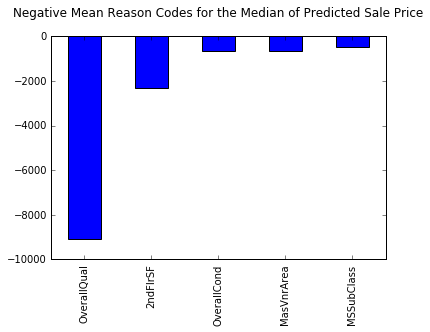

In [18]:
median_mean_loco = loco_ensemble['Mean Local Importance'].sort_values()[:5]
_ = median_mean_loco.plot(kind='bar', 
                          title='Negative Mean Reason Codes for the Median of Predicted Sale Price\n', 
                          legend=False)

#### Positive mean reason codes

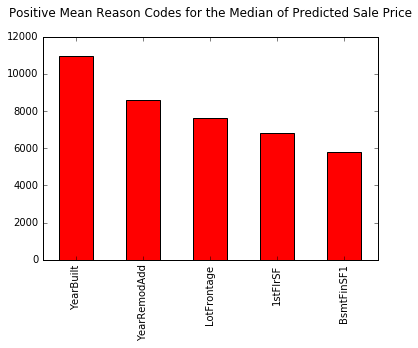

In [19]:
median_mean_loco = loco_ensemble['Mean Local Importance'].sort_values(ascending=False)[:5]
_ = median_mean_loco.plot(kind='bar', 
                          title='Positive Mean Reason Codes for the Median of Predicted Sale Price\n', 
                          color='r',
                          legend=False)

#### Shutdown H2O

In [20]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_af59 closed.
